In [2]:
import os
import re
import sys
sys.path.append('../..')
from gets.get_n import get_n

import numpy as np
import matplotlib.pyplot as plt

def calculate_optical_thickness(d, materials, wl=750):
    optical_thickness = np.dot(d, get_n(wl, materials)[1:-1, 0].real)
    return optical_thickness

def read_final_optical_thickness(fname_d, fname_materials):
    d = np.loadtxt(fname_d, dtype='float')
    materials = np.loadtxt(fname_materials, dtype='str')
    optical_thickness = np.dot(d, get_n(700., materials)[1:-1]).sum()
    return optical_thickness

class SingleRun:
    def __init__(self, **kwargs):
        # self.XXXs must be a np array
        self.merits = None
        self.first_merit = None
        self.last_merit = None
        self.layer_numbers = None
        self.first_layer_number = None
        self.last_layer_number = None
        self.optical_thicknesses = None
        self.first_optical_thickness = None
        self.last_optical_thickness = None
        
        if 'merits' in kwargs.keys():
            self.merits = kwargs['merits']
        if 'first_merit' in kwargs.keys():
            self.first_merit = kwargs['first_merit']
        if 'last_merit' in kwargs.keys():
            self.last_merit = kwargs['last_merit']
        
        if 'layer_numbers' in kwargs.keys():
            self.layer_numbers = kwargs['layer_numbers']
        if 'first_layer_number' in kwargs.keys():
            self.first_layer_number = kwargs['first_layer_number']
        if 'last_layer_number' in kwargs.keys():
            self.last_layer_number = kwargs['last_layer_number']
        
        if 'optical_thicknesses' in kwargs.keys():
            self.optical_thicknesses = kwargs['optical_thicknesses']
        if 'first_optical_thickness' in kwargs.keys():
            self.first_optical_thickness = kwargs['first_optical_thickness']
        if 'last_optical_thickness' in kwargs.keys():
            self.last_optical_thickness = kwargs['last_optical_thickness']

        self.update_all()
    
    def update_all(self):
        self.update_merit_from_merits()
        self.update_layer_from_layers()
        self.update_ot_from_ots()

    def update_merit_from_merits(self):
        if self.merits is not None and self.merits.shape[0] > 1:
            self.first_merit = self.merits[0]
            self.last_merit = self.merits[-1]

    def update_layer_from_layers(self):
        if self.layer_numbers is not None and self.layer_numbers.shape[0] > 1:
            self.first_layer_number = self.layer_numbers[0]
            self.last_layer_number = self.layer_numbers[-1]

    def update_ot_from_ots(self):
        if self.optical_thicknesses is not None and self.optical_thicknesses.shape[0] > 1:
            self.first_optical_thickness = self.optical_thicknesses[0]
            self.last_optical_thickness = self.optical_thicknesses[-1]


    def load_optical_thickness_from_file(self, fpath_d, fpath_materials, pos):
        assert not self.optical_thicknesses, 'ots has been loaded!'
        assert pos == 0 or pos == -1, 'invalid position argument'
        d = np.loadtxt(fpath_d, dtype='str')
        materials = np.loadtxt(fpath_materials, dtype='double')
        this_ot = d * get_n(materials, 700.).sum()
        if pos == 0:
            self.first_optical_thickness = this_ot
        elif pos == -1:
            self.last_optical_thickness = this_ot
    

    @classmethod
    def merge_to_one(cls, *args):
        res = cls(a=1)
        res.first_merit = args[0].first_merit
        res.last_merit = args[-1].last_merit
        res.first_layer_number = args[0].first_merit
        res.last_layer_number = args[-1].last_merit
        res.first_optical_thickness = args[0].first_optical_thickness
        res.last_optical_thickness = args[-1].last_optical_thickness

        # find out whether to connect the 'vars' arrays
        merits = True
        layers = True
        ots = True
        for arg in args:
            if arg.merits is None:
                merits = False
            if arg.layer_numbers is None:
                layers = False
            if arg.optical_thicknesses is None:
                ots = False
        res.merits = None
        res.layer_numbers = None
        res.optical_thicknesses = None
        if merits:
            res.merits = np.array([])
            for arg in args:
                res.merits = np.append(res.merits, arg.merits)
        if layers:
            res.layer_numbers = np.array([])
            for arg in args:
                res.layer_numbers = np.append(res.layer_numbers, arg.layer_numbers)
        if ots:
            res.optical_thicknesses = np.array([])
            for arg in args:
                res.optical_thicknesses = np.append(res.optical_thicknesses, arg.optical_thicknesses)

        res.update_all()
        return res

class MultipleRuns():
    def __init__(self):
        self.last_ots = np.array([])
        self.last_layers = np.array([])
        self.last_merits = np.array([])
        self.first_ots = np.array([])
        self.first_layers = np.array([])
        self.first_merits = np.array([])
    def load_last_data(self, runs):
        assert runs is not None, 'empty input!'
        for run in runs:
            assert run.last_optical_thickness, f'run {run} has undefined last ot!'
            self.last_ots = np.append(self.last_ots, run.last_optical_thickness)
            assert run.last_layer_number, f'run {run} has undefined last layer number!'
            self.last_layers = np.append(self.last_layers, run.last_layer_number)
            assert run.last_merit, f'run {run} has undefined last merit!'
            self.last_merits = np.append(self.last_merits, run.last_merit)
    def load_init_ot(self, runs):
        assert runs is not None, 'empty input!'
        for run in runs:
            assert run.first_optical_thickness, 'undefined init OT!'
            self.first_ots = np.append(self.first_ots, run.first_optical_thickness)
    
               
            

## Add Thickness

In [87]:
class SingleRunAdd(SingleRun):
    def plot(self, otlabel='OTs'):
        fig, ax = plt.subplots(1,1)
        ax.plot(range(self.merits.shape[0]), np.log(self.merits), label='log merits', color='steelblue')
        ax.set_xlabel('insert count')
        tax = ax.twinx()
        tax.plot(range(self.merits.shape[0]), self.layer_numbers, label='layers', color='orange')
        c=0
        # for i in range(self.merits.shape[0]-1):
        #     if self.layer_numbers[i+1] - self.layer_numbers[i] > 2:
        #         c += 1
        #         tax.plot([i, i+1], (self.layer_numbers[i:i+2]), color='green') 
        fig.legend()
        fig.savefig('add_thickness', dpi=600)

        if self.optical_thicknesses is not None:
            fig2, ax2 = plt.subplots(1, 1)
            ax2.plot(range(self.merits.shape[0]), np.log(self.merits), label='log merits', color='steelblue')
            tax2 = ax2.twinx()
            tax2.plot(range(1, self.optical_thicknesses.shape[0] + 1), self.optical_thicknesses.real, label=otlabel, color='forestgreen')
            fig2.legend()
            fig2.savefig('add_thickness_merit_to_ots.png')

def load_ots_with_regexpr(filenames, name_var_list, fpath):
    ots = np.array([])
    for count in name_var_list:
        fname_d = None
        # print(init_ots)
        # find the files 
        for filename in filenames:
            match_obj = re.compile('count{}_layer.*_merit.*'.format(count)).match(filename)

            if match_obj:
                assert fname_d is None, 'multiple files found'
                fname_d = f'./{fpath}/' + match_obj.group()
        assert fname_d is not None, 'file not found'
        
        fname_materials = None
        for filename in filenames:
            match_obj = re.compile('count{}_materials.txt'.format(count)).match(filename)
            if match_obj is not None:
                assert fname_materials is None, 'multiple files found'
                fname_materials = f'./{fpath}/' + match_obj.group()
                # print(fname_materials)
        
        assert fname_materials is not None, 'file not found'
        ots = np.append(ots, read_final_optical_thickness(fname_d, fname_materials))
    return ots



### add thickness 1
- add thickness each time the needle optimization stops
- first append is incorrect

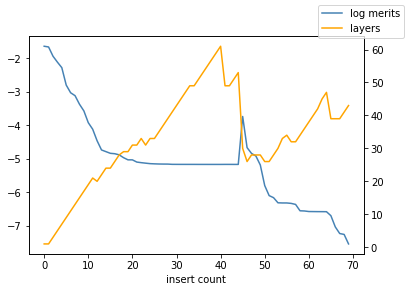

In [2]:
run1_sec1 = SingleRun(layer_numbers=np.loadtxt('add_thickness_wrong/layers_2022-09-21_01-59-59.txt'), merits=np.loadtxt('add_thickness_wrong/merits_2022-09-21_01-59-59.txt'))
run1_sec2 = SingleRun(layer_numbers=np.loadtxt('add_thickness_wrong/layers_2022-09-21_14-52-52.txt'), merits=np.loadtxt('add_thickness_wrong/merits_2022-09-21_14-52-52.txt'))
run1_sec3 = SingleRun(layer_numbers=np.loadtxt('add_thickness_wrong/layers_2022-09-22_02-54-54.txt'), merits=np.loadtxt('add_thickness_wrong/merits_2022-09-22_02-54-54.txt'))
run1_sec4 = SingleRun(layer_numbers=np.loadtxt('add_thickness_wrong/layers_2022-09-23_08-49-49.txt'), merits=np.loadtxt('add_thickness_wrong/merits_2022-09-23_08-49-49.txt'))

SingleRunAdd.merge_to_one(run1_sec1, run1_sec2, run1_sec3, run1_sec4).plot()
# print(add_merits)


### add thickness 2
- redo, so that appends are correct.
- target ot = 4080 nm

target ot is 4080.6662364356243
final ot is 8770.965069310314


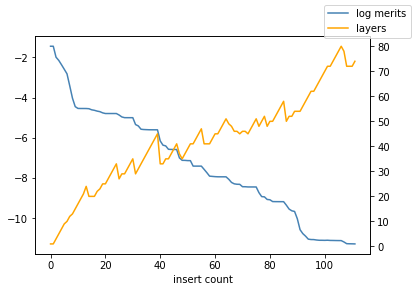

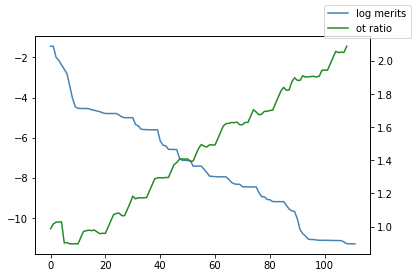

In [83]:
run2_sec1 = SingleRun(layer_numbers=np.loadtxt('add_thickness_SiO2/layers_2022-09-23_07-57-57.txt'), merits=np.loadtxt('add_thickness_SiO2/merits_2022-09-23_07-57-57.txt'))
run2_sec2 = SingleRun(layer_numbers=np.loadtxt('add_thickness_SiO2/layers_2022-09-28_10-08-54.txt'), merits=np.loadtxt('add_thickness_SiO2/merits_2022-09-28_10-08-54.txt'))

run2 = SingleRunAdd.merge_to_one(run2_sec1, run2_sec2)
fpath = './add_thickness_SiO2/generated_data'
run2.optical_thicknesses = load_ots_with_regexpr(os.listdir(fpath), range(1, 110), fpath) / 4080

run2.plot(otlabel='ot ratio')

d_target = np.array([123, 456, 789, 234, 567], dtype='double')
materials_target = np.array([])
available_materials = np.array(['SiO2', 'TiO2'])
for i in range(d_target.shape[0]):
    materials_target = np.append(materials_target, available_materials[i % 2])
print(f'target ot is {calculate_optical_thickness(d_target, materials_target, wl=600.)}')
final_d = np.loadtxt('./add_thickness_SiO2/generated_data/count110_layer76_merit1.2661786746821295e-05.txt')
final_materials = np.loadtxt('./add_thickness_SiO2/generated_data/count110_materials.txt', dtype='str')
print(f'final ot is {calculate_optical_thickness(final_d, final_materials, wl=600.)}')


### add thickness 3
- target 50 layers, target OT 5061nm
- init OT ratio = 2

target OT is 5061.081268090234
final ot is 10191.109761093836
2.013633669235329


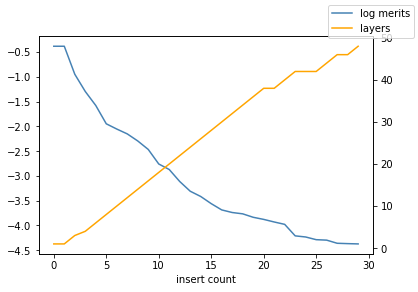

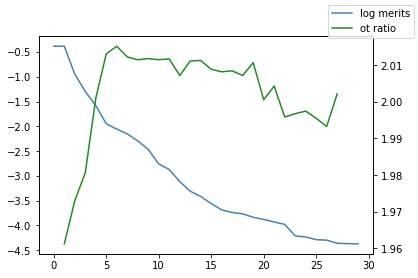

In [88]:
# target OT
np.random.seed(1)
d_target = np.random.random(50) * 100
materials_target = np.array([])
available_materials = np.array(['SiO2', 'TiO2'])
for i in range(d_target.shape[0]):
    materials_target = np.append(materials_target, available_materials[i % 2])
print(f'target OT is {calculate_optical_thickness(d_target, materials_target, wl=600.)}')
# final OT
final_d = np.loadtxt('./add_thickness_SiO2_50_layer_target_1/generated_data/count28_layer48_merit0.012697182106626638.txt')
final_materials = np.loadtxt('./add_thickness_SiO2_50_layer_target_1/generated_data/count28_materials.txt', dtype='str')
print(f'final ot is {calculate_optical_thickness(final_d, final_materials, wl=600.)}')
print(10191 / 5061)

run3_sec1 = SingleRun(layer_numbers=np.loadtxt('add_thickness_SiO2_50_layer_target_1/layers_2022-09-29_10-22-25.txt'), merits=np.loadtxt('add_thickness_SiO2_50_layer_target_1/merits_2022-09-29_10-22-25.txt'))
run3 = SingleRunAdd.merge_to_one(run3_sec1)
fpath = './add_thickness_SiO2_50_layer_target_1/generated_data'
run3.optical_thicknesses = load_ots_with_regexpr(os.listdir(fpath), range(1, 28), fpath) / 5061

run3.plot(otlabel='ot ratio')



### add thickness 4
- target 50 layers, target OT 5061 nm
- init OT ratio = 5

target OT is 5061.081268090234
final ot is 24906.61552425632


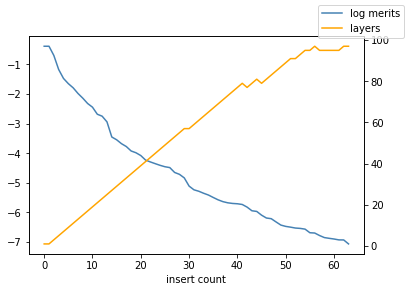

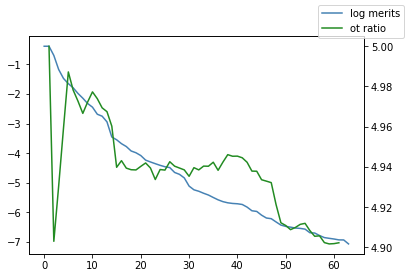

In [96]:
# target OT
np.random.seed(1)
d_target = np.random.random(50) * 100
materials_target = np.array([])
available_materials = np.array(['SiO2', 'TiO2'])
for i in range(d_target.shape[0]):
    materials_target = np.append(materials_target, available_materials[i % 2])
print(f'target OT is {calculate_optical_thickness(d_target, materials_target, wl=600.)}')
# final OT
final_d = np.loadtxt('./add_thickness_SiO2_50_layer_target_2/generated_data/count55_layer97_merit0.0012373816843633412.txt')
final_materials = np.loadtxt('./add_thickness_SiO2_50_layer_target_2/generated_data/count55_materials.txt', dtype='str')
print(f'final ot is {calculate_optical_thickness(final_d, final_materials, wl=600.)}')



run4_sec1 = SingleRun(layer_numbers=np.loadtxt('add_thickness_SiO2_50_layer_target_2/layers_2022-09-30_23-35-45.txt'), merits=np.loadtxt('add_thickness_SiO2_50_layer_target_2/merits_2022-09-30_23-35-45.txt'))
run4 = SingleRunAdd.merge_to_one(run4_sec1)
fpath = './add_thickness_SiO2_50_layer_target_2/generated_data'
run4.optical_thicknesses = np.insert(load_ots_with_regexpr(os.listdir(fpath), range(1, 61), fpath)/5061, 0, 5.)

run4.plot(otlabel='ot ratio')


## Different OT

### different ot 1
- target: 5 layers
- initial layers: Sio2, TiO2, substrate SiO2

[ 2180.65193686+0.j  2750.52372482+0.j  1912.15850418+0.j
  3308.61596885+0.j  3876.55243122+0.j  3876.55248538+0.j
  4767.56927521+0.j  1912.15947116+0.j  1912.1584955 +0.j
  3876.55235694+0.j  3876.55262532+0.j  6780.86267563+0.j
 33808.36635535+0.j  1912.15946255+0.j  7997.96675294+0.j]


d:\Anaconda\envs\math\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Anaconda\envs\math\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


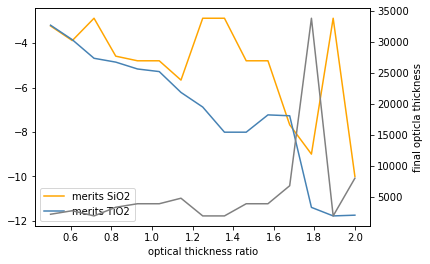

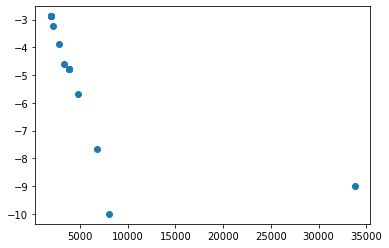

In [23]:
merits_diff_ratio_SiO2 = np.array([3.967303739448601457e-02, 2.052521239401709080e-02, 5.605258812616412123e-02, 1.017814017527631995e-02, 8.268337491871427872e-03, 8.268337312807424663e-03, 3.469239999230585257e-03
, 5.605258812616507186e-02, 5.605258812616394776e-02, 8.268337466800992561e-03, 8.268337464495241484e-03, 4.645829760843806985e-04, 1.242087195168543011e-04, 5.605258812616478042e-02, np.e**(-10)])
ratios_diff_raiot = np.linspace(0.5, 2., 15)
merits_diff_ratio_TiO2 = np.array([4.100455703250070749e-02, 2.135026997353847364e-02, 9.255427763962573856e-03, 7.785665714543050370e-03
, 0.005720866029127131 , 5.088601609987766783e-03, 1.992316199939797410e-03, 0.0010326838417552059, 3.330811001487302288e-04,
 3.330809649289658610e-04, 7.253934313144339962e-04, 6.970760909041970712e-04, 1.1312456646605904e-05, 7.70536084578263e-06, 7.964892916537034e-06])



filenames = os.listdir('./calc_final_optical_thickness')

# terrible file names, have to use regular expressions to load...
def find_file_name_with_regexpr(name_var_list, fpath):
    ot_diff_SiO2 = np.array([])
    for init_ots in name_var_list:
        fname_d = None
        # print(init_ots)
        # find the files 
        for filename in filenames:
            match_obj = re.compile('ratio_{}.*_.*_.*_.*'.format(init_ots)).match(filename)

            if match_obj:
                assert fname_d is None, 'multiple files found'
                fname_d = f'./{fpath}/' + match_obj.group()
        assert fname_d is not None, 'file not found'
        
        fname_materials = None
        for filename in filenames:
            match_obj = re.compile('ratio_{}.*_.*_.*materials.txt'.format(init_ots)).match(filename)
            if match_obj is not None:
                assert fname_materials is None, 'multiple files found'
                fname_materials = f'./{fpath}/' + match_obj.group()
                # print(fname_materials)
        
        assert fname_materials is not None, 'file not found'
        ot_diff_SiO2 = np.append(ot_diff_SiO2, read_final_optical_thickness(fname_d, fname_materials))
    return ot_diff_SiO2

ot_SiO2 = find_file_name_with_regexpr(np.linspace(0.5, 2, 15), 'calc_final_optical_thickness_diff_init_ot')
print(ot_SiO2)


# plot
fig, ax_merits = plt.subplots(1, 1)
ax_fot = ax_merits.twinx()
ax_fot.plot(ratios_diff_raiot, ot_SiO2, color='grey', label='SiO2 optical thickness')
ax_fot.set_ylabel('final opticla thickness')
ax_merits.set_xlabel('optical thickness ratio')
ax_merits.plot(ratios_diff_raiot, np.log(merits_diff_ratio_SiO2), color='orange', label='merits SiO2')
ax_merits.plot(ratios_diff_raiot, np.log(merits_diff_ratio_TiO2), color='steelblue', label='merits TiO2')
ax_merits.legend()

fig.savefig('SiO2_and_TiO2', dpi=600)


fig2, ax = plt.subplots(1, 1)
ax.scatter(ot_SiO2, np.log(merits_diff_ratio_SiO2))


##### At initial ratio ~ 1.8, final ot very large
- SiO2-TiO2 thickness ratio about $10^3$ throughout almost the whole structure
- total thickness of TiO2: 117nm
- how to explain? thin layers should have no effect?
- 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\weenming\AppData\Local\Temp\ipykernel_68236\2945433327.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pi" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('layers_plot_very_thick.png', pi=600, )


117.08953576479188


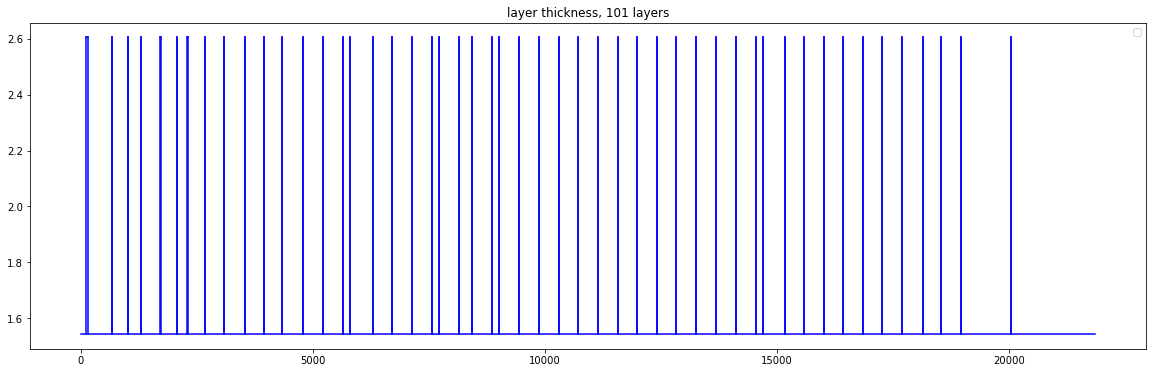

In [29]:
plt.rcParams['figure.figsize'] = 20, 6

def plot_layer_thickness(d, materials, insert_layer_num=-1, last_insert_layer_thickness=None):
    d_plot = 0
    layer_number = d.shape[0]
    fig, ax = plt.subplots(1, 1)
    for i in range(layer_number):
        # 以600nm的折射率表示
        n_plot = get_n(600, materials)[i + 1].real
        n_last_plot = get_n(600, materials)[i].real
        if i == insert_layer_num:
            ax.plot([d_plot, d_plot + d[i]], [n_plot, n_plot], color='red',
                     label=f'thickness={last_insert_layer_thickness}')
        else:
            ax.plot([d_plot, d_plot + d[i]], [n_plot, n_plot], color='blue')
        if i != 0:
            ax.plot([d_plot, d_plot], [n_plot, n_last_plot], color='blue')
        d_plot += d[i]
    ax.legend()
    ax.set_title(f'layer thickness, {layer_number} layers')
    fig.savefig('layers_plot_very_thick.png', pi=600, )

    return

def plot_very_large_thickness():
    d = np.loadtxt('calc_final_optical_thickness/ratio_1.7857142857142856_count50_layer99_merit0.0001242087195168543.txt')
    materials = np.loadtxt('calc_final_optical_thickness/ratio_1.7857142857142856_count50_materials.txt', dtype='str')
    plot_layer_thickness(d, materials)
    d_TiO2 = 0
    for i in range(d.shape[0]):
        if materials[i] == 'TiO2':
            d_TiO2 += d[i]
    print(d_TiO2)

def plot_normal_layer_thickness():
    d = np.loadtxt('calc_final_optical_thickness/ratio_2.0_count49_layer72_merit3.0599687995372325e-05.txt')
    materials = np.loadtxt('calc_final_optical_thickness/ratio_2.0_count49_materials.txt', dtype='str')
    plot_layer_thickness(d, materials)

    

# plot_normal_layer_thickness()
plot_very_large_thickness()



### different thickness 2
- target: 30 layers

## Layer-thickness-merit Relation

### layer-thickness-merit (final) (1)
- target: 30 layers, total ot = 2914nm

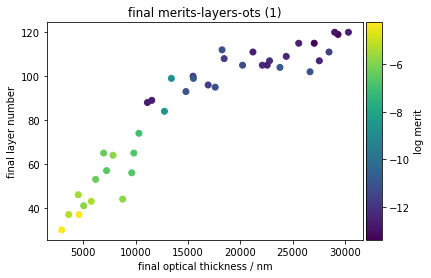

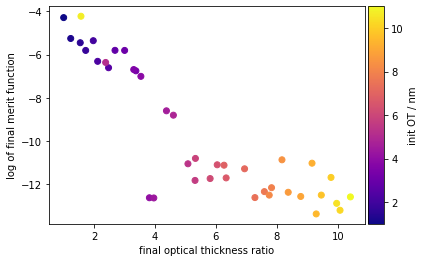

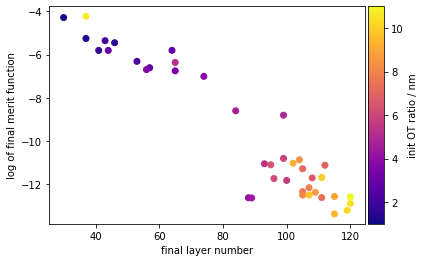

In [39]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

runs = np.array([])
for init_ot in np.linspace(1, 11, 40):
    last_ot = np.loadtxt(f'../layer_thickness_merit_1/send/ratio_{init_ot}_ots_2022-09-24_19-27-26.txt')[-1]
    last_layer = np.loadtxt(f'../layer_thickness_merit_1/send/ratio_{init_ot}_layers_2022-09-24_19-27-26.txt')[-1]
    last_merit = np.loadtxt(f'../layer_thickness_merit_1/send/ratio_{init_ot}_merits_2022-09-24_19-27-26.txt')[-1]
    runs = np.append(runs, SingleRun(last_optical_thickness=last_ot, last_layer_number=last_layer, last_merit=last_merit, first_optical_thickness=init_ot))
runs_temp = runs.copy()
runs = MultipleRuns()
runs.load_last_data(runs_temp)
runs.load_init_ot(runs_temp)
# fig: merit-layer-ot
fig, ax = plt.subplots(1, 1)
s = ax.scatter(runs.last_ots, runs.last_layers, c=np.log(runs.last_merits), cmap='viridis')
ax.set_xlabel('final optical thickness / nm')
ax.set_ylabel('final layer number')
ax.set_title('final merits-layers-ots (1)')
cbar = plt.colorbar(s, cax=make_axes_locatable(ax).append_axes("right", size='5%', pad=0.05))
cbar.set_label('log merit')
# ax.annotate('30 layer target\nsome runs (with large ots) \nhave not terminated', xy=(15000, 40))
fig.savefig('merit_layer_ot_1.png', dpi=800)

# fig: merit-ot
fig2, ax2 = plt.subplots(1, 1)
s2 = ax2.scatter(runs.last_ots/2914, np.log(runs.last_merits), c=runs.first_ots, cmap='plasma')
ax2.set_xlabel('final optical thickness ratio')
ax2.set_ylabel('log of final merit function')
cbar2 = plt.colorbar(s2, cax=make_axes_locatable(ax2).append_axes("right", size='5%', pad=0.05))
cbar2.set_label('init OT / nm')
fig2.savefig('merit_ot_1.png', dpi=600)

# fig: merit-layer number
fig3, ax3 = plt.subplots(1, 1)
s3 = ax3.scatter(runs.last_layers, np.log(runs.last_merits), c=runs.first_ots, cmap='plasma')
ax3.set_xlabel('final layer number')
ax3.set_ylabel('log of final merit function')
cbar3 = plt.colorbar(s3, cax=make_axes_locatable(ax3).append_axes("right", size='5%', pad=0.05))
cbar3.set_label('init OT ratio / nm')
fig3.savefig('merit_layer_1.png', dpi=600)

In [6]:
# target OT
np.random.seed(1)
d_target = np.random.random(30) * 100
materials_target = np.array([])
available_materials = np.array(['SiO2', 'TiO2'])
for i in range(d_target.shape[0]):
    materials_target = np.append(materials_target, available_materials[i % 2])
print(calculate_optical_thickness(d_target, materials_target, wl=600.))

2914.701738605815


[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01 4.19194514e-01 6.85219500e-01
 2.04452250e-01 8.78117436e-01 2.73875932e-02 6.70467510e-01
 4.17304802e-01 5.58689828e-01 1.40386939e-01 1.98101489e-01
 8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
 8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02
 1.69830420e-01 8.78142503e-01]
